In [1]:
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from collections import Counter
import re
import spacy

%matplotlib inline
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn import tree,model_selection
import gensim
from gensim import corpora, models, similarities
import pyLDAvis.gensim as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Below , i am using twitter api to get real time tweets for some famous politicians- Donald Trump,Hillary Clinton,Barnie Sanders and Barack Obama.Lets try to classify their tweets to check of the accuracy for the labelling.

In [2]:
import tweepy
consumer_key = '66n3K6o0GfkbLO4QEoqRCA2pZ'
consumer_secret = 'T1fsUWei3jSvOehl9TmRqIuIhTGi0UEudOAeT04PMLcgodQzhS'
access_token = '86377594-cpO17ciBmTRbHzKD0AikvyIgJg7Ohfj5klfTogjVh'
access_token_secret = 'pMIxRtyha7XNeyBITlLwprYGwfl2DM4laCB2dUaDXCrCA'
 
def  twitter_Access():
     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
     auth.set_access_token(access_token, access_token_secret)
     api = tweepy.API(auth, wait_on_rate_limit=True)
     return api
extract = twitter_Access()

First of all, I am creating a file for each politican and saving there latest 200 tweets in a file and then retrieving them

In [16]:

#Twitter's API only allows for 200 records per call
TWEETS_PER_CALL = 200 

def save_tweets(screen_nm, tweets):
    # 'a' appends to the .json we wrote with 'w' above
    with open(f'C:\\Users\\Ankush\\Desktop\\{screen_nm}.json', 'a') as f:
        for tweet in tweets:
            json.dump([tweet.text, screen_nm], f); f.write('\n')

def get_tweets(screen_nm, desired_ct):
    
    #desired_ct is the number of tweets the user wants to include
    tweet_list = []

    #grab the current maximum tweet id for provided screen name, which will be the id of the first tweet stored in the object
    tweets = extract.user_timeline(screen_name = screen_nm,count=50)
    save_tweets(screen_nm, tweets)
    return tweet_list

In [17]:
trump = get_tweets('realDonaldTrump',50)
clinton = get_tweets('HillaryClinton', 50)
bernie = get_tweets('SenSanders', 50)
obama = get_tweets('BarackObama', 50)


In [5]:
handles = ['realDonaldTrump', 'HillaryClinton', 'SenSanders', 'BarackObama', 'MikeBloomberg']


Now, lets combine all the tweets in one list and then into a dataframe so that we can ceate two columns- tweets and the author

In [18]:

#Combine all tweets into 1 list

full_tweets = []
for handle in handles:
    with open('C:\\Users\\Ankush\\Desktop\\{}.json'.format(handle)) as f: 
        full_tweets.append([json.loads(line) for line in f])
        
#Only want the first 2100 from each author (retweets caused the full amount for each author to be < 3200, and each has at least
#2100 non RTs)
all_tweets = []
for auth in full_tweets:
    all_tweets.extend(auth[:500])
    
#Store in dataframe
tweet_df = pd.DataFrame(all_tweets, columns = ['Tweets', 'Author'])

In [137]:
tweet_df.head()

,Tweets,Author,MiniBatchLabels
0,....This will be remembered as one of the most...,realDonaldTrump,1
1,Senate Democrats just voted against legislatio...,realDonaldTrump,5
2,"If a deal is made with China, our great Americ...",realDonaldTrump,6
3,Heading over to Vietnam for my meeting with Ki...,realDonaldTrump,1
4,China Trade Deal (and more) in advanced stages...,realDonaldTrump,1


In [12]:
tweet_df.head()

,Tweets,Author
0,....This will be remembered as one of the most...,realDonaldTrump
1,Senate Democrats just voted against legislatio...,realDonaldTrump
2,"If a deal is made with China, our great Americ...",realDonaldTrump
3,Heading over to Vietnam for my meeting with Ki...,realDonaldTrump
4,China Trade Deal (and more) in advanced stages...,realDonaldTrump


Now, we are trying to remove uneven word space and trying to join the words with single space

In [19]:
tweet_full= ' '.join(tweet_df['Tweets'])

Now, we can parse the cleaned data into tokens as below

In [20]:
nlp = spacy.load('en')
tweet_full=nlp(tweet_full)

In [21]:
def bag_of_words(text):
    allwords = [token.lemma_ for token in text if not token.is_stop and not token.is_punct and not token.like_url and 
                not token.like_num and not token.is_space and token.is_ascii and len(token.lemma_) > 1]
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]

In [22]:
bow = bag_of_words(tweet_full)

#Let's clean this up a bit 
replace_words = [r'/n', r'\\n', r'\n', r'--', r'-', 'https:\/\/t\.co\/[\w\d]+', r'amp', r'&', r'w/', "'s"]
bow = [re.sub('|'.join(replace_words), '', word) for word in bow]

In [26]:
#Create dataframe with counts of our bag of words as features 
def bow_features(sentences, bow):
    
    partsofspeechlist = []
    ent_list = []
    
    for sent in sentences[0]:
        for token in sent:
                partsofspeechlist.append(token.pos_)

    parts = (set(partsofspeechlist))

    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns = set(list(bow)+ list(parts)))
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, bow] = 0
    #df['tweet_length'] = 0
    #df['tweet_punct_count'] = 0 
    #df['upper_case'] = 0 
    df.loc[:, parts] = 0
    
    for i, sent in enumerate(sentences[0]):

        tweet_len = 0    
        num_punct = 0
        
        # Populate the row with word counts (only include the ones from our bag of words)
        words = [token.lemma_ for token in sent
                 if token.lemma_ in bow]
        
        #"words" collects all bow matches from each sentence
        for word in words:
            df.loc[i, word] += 1
        
        #Add part of speech counter and tweet length
        for token in sent:
            df.loc[i, token.pos_] += 1
            if not token.is_punct:
                tweet_len += 1
            else:
                num_punct += 1
            
        #Create a feature for all CAPS words  
           # if ((str(token).isupper()) & (len(str(token)) > 1)):
             #   df.loc[i, 'upper_case'] += 1


        #df.loc[i, 'tweet_length'] = tweet_len
        #df.loc[i, 'tweet_punct_count'] = num_punct

        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))

    return df

In [27]:
#Tokenize our tweets using spaCy (for more interesting features later on)
all_tweets_nlp = []
all_tweets_nlp.append([nlp(tweet[0]) for tweet in all_tweets])
all_tweets_nlp.append([nlp(tweet[1]) for tweet in all_tweets])

In [28]:
df = bow_features(all_tweets_nlp, bow)
df.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000


,,robinson,strength,deal,low,abuse,murder,safe,teach,throw,...,allow,truly,iowa,venezuela,american,prince,deliver,network,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(...., This, will, be, remembered, as, one, of...",(realDonaldTrump)
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Senate, Democrats, just, voted, against, legi...",(realDonaldTrump)
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"(If, a, deal, is, made, with, China, ,, our, g...",(realDonaldTrump)
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Heading, over, to, Vietnam, for, my, meeting,...",(realDonaldTrump)
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(China, Trade, Deal, (, and, more, ), in, adva...",(realDonaldTrump)


# Supervised Learning

We can now use all the supervised learning models for classification since we have input variables and labels both

# Random Forest

In [39]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
X = np.array(df.drop(['text_sentence', 'text_source'],1))

#y needs to be str or int, cannot be spacy doc, so convert here
Y = df['text_source'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_train)



print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9973333333333333

Test set score: 0.883


Wow, looks like there is overfitting in training and test data both.This might have been because of high number of features.It is suspectable to random noise which we can oberserve by looking at overfitting.Random forest/Decision tree doesnot perform well with huge number of features as above.Using Gridsearch cv will not really help here either.So, we should ignore this model

In [30]:
lr = LogisticRegression(C=1e9)
lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 1.0

Test set score: 0.918


Same has happend for Logisic Regression,lot of overfitting.

In [40]:
#KNN
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_train)
print('Training set score:', knn_model.score(X_train, y_train))
print('\nTest set score:', knn_model.score(X_test, y_test))

Training set score: 0.9233333333333333

Test set score: 0.69


KNN has peformed better then random forest and Logistic Regression.The reason being  that it is robust to random noise which we can observe looking at the dataset.Also, this model performs better for large dataset which is applicable to this dataset.We need to play around with number of neighbours to get the best accuracy.In this case, if we increase the neighbours, accuracy will decrease.The reason being the huge amount of data in the dataset which is affecting the accuracy.

# Cross Validation Score

In [36]:
from sklearn.model_selection import cross_val_score
print("Training data accuracy : ",cross_val_score(knn_model, X_train, y_train, cv=10))
print("Testing data accuracy : ",cross_val_score(knn_model, X_test, y_test, cv=10))

Training data accuracy :  [0.61437908 0.64900662 0.67333333 0.63333333 0.57333333 0.56666667
 0.59333333 0.61744966 0.63758389 0.59459459]
Testing data accuracy :  [0.64705882 0.4950495  0.55445545 0.42       0.54       0.49
 0.47       0.59       0.54545455 0.5257732 ]


# Confusion Matrix

In [43]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(confusion_matrix(y_train, y_pred_knn))
print('Accuracy Score:',accuracy_score(y_train, y_pred_knn))

[[299   0   0   0   0]
 [ 14 278   0   0   0]
 [ 15  16 260   0   0]
 [  9  15  11 276   0]
 [ 10  11   5   9 272]]
Accuracy Score: 0.9233333333333333


# Classification Report

In [44]:
#Classification Report
from sklearn.metrics import classification_report
print("Classification Report :",classification_report(y_train, y_pred_knn))

Classification Report :                  precision    recall  f1-score   support

    BarackObama       0.86      1.00      0.93       299
 HillaryClinton       0.87      0.95      0.91       292
  MikeBloomberg       0.94      0.89      0.92       291
     SenSanders       0.97      0.89      0.93       311
realDonaldTrump       1.00      0.89      0.94       307

      micro avg       0.92      0.92      0.92      1500
      macro avg       0.93      0.92      0.92      1500
   weighted avg       0.93      0.92      0.92      1500



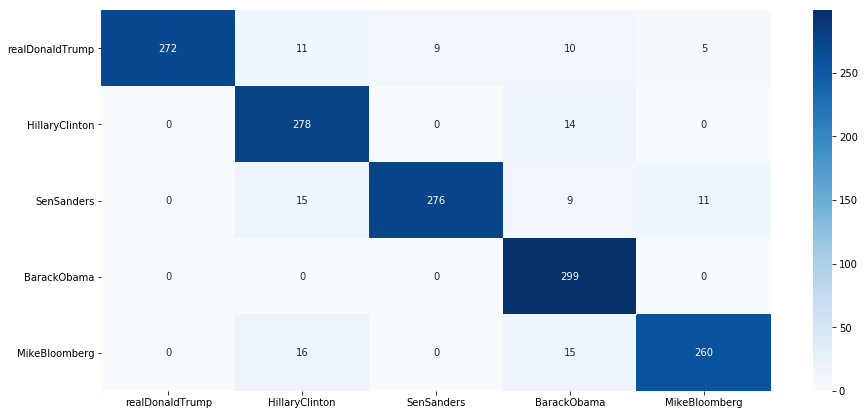

In [47]:
conf = confusion_matrix(y_train, y_pred_knn, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

The accuracies for cross validation,confusion matrix, classification report look good.These are good numbers keeping in mind, all the labels have good accuracy.Labels for barack obama and donald trump have little overfitting but overall its performed well.The overfitting is very less if we see the confusion matrix above for the labels.Thats make it a good model to apply.Also, we were not able to AUC since its appliaction is limited to  binary labels

Now, lets use unsupervised learning since we have learned a fair amount of that.Lets apply that to this dataset and see how it behaves to this dataset

# Unsupervised Learning

Lets do k means cluster and check how it peformed with the dataset.First we will take value using tfidfvectoizer and convert into tokens and classify the data per cluster

In [48]:
vector = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=2, # only use words that appear at least 2x
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )




In [54]:
#Let's keep our data in high dimensional form first, to see what (if any) insights we can gain from clustering.

#Try K-Means MiniBatch (K-Means is very resource intensive for high dimnesional data) and assume 10 clusters to begin with

#Create normalized version of full dataset (we don't need to reserve any for training, we just want to cluster for now)

#Normalize the data to the unit vector. Should we normalize by row or column? Normalize by row - gives a better representation of tweet composition. Likely more meaningful than the relative freq magnitude
#of each word relative to that word's frequencies in all tweets

X = tweet_df['Tweets']
X_norm_tfidf = normalize(vector.fit_transform(X))

true_k = 10
labels_class = Y
km = KMeans(n_clusters=10,init='k-means++',random_state=42)
y_pred=KMeans(n_clusters=10, random_state=42).fit_predict(X_norm_tfidf)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_norm_tfidf)
labels = km.labels_
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_class, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels_class, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_class, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels_class, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_norm_tfidf, km.labels_, sample_size=5000))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Homogeneity: 0.070
Completeness: 0.054
V-measure: 0.061
Adjusted Rand-Index: 0.025
Silhouette Coefficient: 0.010


In [57]:
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_norm_tfidf)
print(pd.crosstab(y_pred, labels_class))

text_source  BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
row_0                                                                 
0                     10              35             44          15   
1                     95              50             36          66   
2                     73              65             70          53   
3                    148             152             97         126   
4                     74              61             78          46   
5                     25              18             25          23   
6                     12               8             71          19   
7                     20              35             49           3   
8                     10              34             18         145   
9                     33              42             12           4   

text_source  realDonaldTrump  
row_0                         
0                         36  
1                         42  
2                      

Overall results are poor.It looks like there is no clear classification for all the labels and most of labels are overlapping,which is not a good sign.Lets use min batch k-means.Usually it improves clustering,

# Mini Batch KMeans

In [66]:
labels = Y
km = MiniBatchKMeans(n_clusters=15, init='k-means++', batch_size=2000)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_norm_tfidf)
mini_labels = km.labels_
print("Done in %0.3fs" % (time() - t0))
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_norm_tfidf, km.labels_, sample_size=1000))

Clustering sparse data with MiniBatchKMeans(batch_size=2000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=15,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Done in 0.249s

Homogeneity: 0.098
Completeness: 0.063
V-measure: 0.076
Adjusted Rand-Index: 0.030
Silhouette Coefficient: 0.013


In [67]:
tweet_df['MiniBatchLabels'] = mini_labels
for label in set(mini_labels):
    print('Cluster: %d' % label)
    print(tweet_df[tweet_df.MiniBatchLabels == label].groupby('Author').count())
    

Cluster: 0
                 Tweets  MiniBatchLabels
Author                                  
BarackObama          14               14
HillaryClinton       29               29
MikeBloomberg        18               18
SenSanders           64               64
realDonaldTrump      30               30
Cluster: 1
                 Tweets  MiniBatchLabels
Author                                  
BarackObama          99               99
HillaryClinton      106              106
MikeBloomberg        69               69
SenSanders           79               79
realDonaldTrump     101              101
Cluster: 2
                 Tweets  MiniBatchLabels
Author                                  
BarackObama          23               23
HillaryClinton       26               26
MikeBloomberg        44               44
SenSanders           44               44
realDonaldTrump      19               19
Cluster: 3
                 Tweets  MiniBatchLabels
Author                                  
BarackObama  

We have to play around with  the values of number of clusters, clusters between 10 and 15 seems to produce better results than less clusters.Lets get into more details and try to check the tweets for some of the clusters

In [68]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 0]).head(10)

,Tweets,Author,MiniBatchLabels
1017,"The American people, the Congress and the cour...",SenSanders,0
1130,The Saudi-led war in Yemen has been a humanita...,SenSanders,0
317,RT @WhiteHouse: .@PressSec: President Trump wi...,realDonaldTrump,0
2300,RT @GovernorTomWolf: The heroin and opioid epi...,MikeBloomberg,0
1536,I am grateful for the next generation of leade...,BarackObama,0
1348,At a time of massive wealth and income inequal...,SenSanders,0
770,The government shutdown is by far the longest ...,HillaryClinton,0
1186,Mr. President. Stop holding federal employees ...,SenSanders,0
99,THE RIGGED AND CORRUPT MEDIA IS THE ENEMY OF T...,realDonaldTrump,0
442,God Bless the people of Venezuela!,realDonaldTrump,0


In [69]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 2]).head(10)

,Tweets,Author,MiniBatchLabels
2006,Congratulations to @GovSisolak and Nevada’s le...,MikeBloomberg,2
2442,The U.S. &amp; Canada are bound together not o...,MikeBloomberg,2
1497,I stand with @transportworker fighting to keep...,SenSanders,2
1007,Catalyst's decision to raise the price of a li...,SenSanders,2
2450,"In 2018, @Bloomberg employees gave more than 1...",MikeBloomberg,2
519,The real national emergencies:\n\n- Relentless...,HillaryClinton,2
329,The Gallup Poll just announced that 69% of our...,realDonaldTrump,2
982,RT @ChelseaClinton: Measles cases surged 30% l...,HillaryClinton,2
2159,"With Washington asleep at the wheel, cities of...",MikeBloomberg,2
1906,"In the year since their friends were killed, t...",BarackObama,2


In [73]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 14]).head(10)

,Tweets,Author,MiniBatchLabels
1883,Tens of millions of Americans have benefited f...,BarackObama,14
1139,As a nation we have a choice: are we going to ...,SenSanders,14
532,"Now copy my plan on health care, a fairer tax ...",HillaryClinton,14
2103,"To combat the opioid epidemic, we'll bring tog...",MikeBloomberg,14
2217,Coal pollution has real consequences for our e...,MikeBloomberg,14
1693,"Speak up in support of quality, affordable hea...",BarackObama,14
1722,"Leaders like Dejah Powell, who started an orga...",BarackObama,14
2120,"Ending the opioid epidemic requires bold, urge...",MikeBloomberg,14
1106,Every other major country has made the morally...,SenSanders,14
733,Only about 1% of abortions happen later in pre...,HillaryClinton,14


The above shows some of the tweets with their clusters.We did this to get some idea of clusters with their tweets and the author for the tweets

In [131]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm_tfidf.toarray(), quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm_tfidf.toarray())

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


# BoW Feature


In [111]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [112]:
train_data_bow = count_vect.fit_transform(X_train)

In [114]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Random Forest Classifier
rfc_bow1 = ensemble.RandomForestClassifier(random_state=42)
rfc_bow1.fit(train_data_bow,y_train)
cv_bow1 = cross_val_score(rfc_bow1, train_data_bow, y_train, cv=5)


#Test
y_true, y_pred = y_train, rfc_bow1.predict(train_data_bow)
print("Test Set score = {:.3} ".format(accuracy_score(y_true, y_pred)))


print("Training set Cross validation = {}".format(cv_bow1))
print("mean = {:.3}".format(cv_bow1.mean()))
print(pd.crosstab(y_true, y_pred))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test Set score = 0.998 
Training set Cross validation = [0.84350133 0.856      0.88266667 0.9171123  0.86898396]
mean = 0.874
col_0            BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
Author                                                                    
BarackObama              359               0              0           0   
HillaryClinton             0             389              0           0   
MikeBloomberg              0               0            381           0   
SenSanders                 0               0              0         373   
realDonaldTrump            0               0              0           0   

col_0            realDonaldTrump  
Author                            
BarackObama                    2  
HillaryClinton                 1  
MikeBloomberg                  0  
SenSanders                     0  
realDonaldTrump              370  


Overfitting again.The model doesnt look accuarate enough.Lets check SVC

In [127]:

from sklearn.metrics import confusion_matrix


knn_model_bow = KNeighborsClassifier(n_neighbors=2)
knn_model_bow.fit(train_data_bow,y_train)
knn_model_cv = cross_val_score(knn_model_bow, train_data_bow, y_train, cv=10)


print("Report:")
y_true, y_pred = y_train, knn_model_bow.predict(train_data_bow)
#print(classification_report(y_true, y_pred))

print("Test Set score = {:.3} ".format(accuracy_score(y_true, y_pred)))


print("Training set Cross validation = {}".format(knn_model_cv))
print("mean = {:.3}".format(knn_model_cv.mean()))
pd.crosstab(y_true, y_pred)

Report:
Test Set score = 0.995 
Training set Cross validation = [0.76315789 0.83510638 0.79787234 0.81818182 0.78609626 0.80748663
 0.81818182 0.81283422 0.86096257 0.80748663]
mean = 0.811


col_0,BarackObama,HillaryClinton,MikeBloomberg,SenSanders,realDonaldTrump
Author,,,,,
BarackObama,361,0,0,0,0
HillaryClinton,0,390,0,0,0
MikeBloomberg,1,2,378,0,0
SenSanders,1,2,2,368,0
realDonaldTrump,1,1,0,0,368


The above looks to be better than any other models.There looks to be some overfitting but cross validation is better than other models.Mean value is better as well.Over all ,I am happy with this since it is performing better 

# Latent Semantic Analysis


Let's use Latent Semantic Analysis to reduce the tf-idf into a lower dimensional space. This is similar to Principal Component Analysis (PCA), where we reduce the number of rows and combine them into new dimensions.

In [85]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

songs_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(10):
    print('Component {}:'.format(i))
    print(songs_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 92.2670769445096
Component 0:
Tweets
RT @IndivisibleTeam: Trump just declared a #FAKENationalEmergency at the border. Trump is going around Congress, the will of the people, &amp;…    0.319650
RT @IndivisibleTeam: Trump just declared a #FAKENationalEmergency at the border. Trump is going around Congress, the will of the people, &amp;…    0.319650
RT @IndivisibleTeam: Trump just declared a #FAKENationalEmergency at the border. Trump is going around Congress, the will of the people, &amp;…    0.319650
The Bloomberg American Cities Climate Challenge supports new ideas for fighting climate change &amp; strong mayors who… https://t.co/eG9jKdjyqt    0.290468
The Bloomberg American Cities Climate Challenge supports new ideas for fighting climate change &amp; strong mayors who… https://t.co/eG9jKdjyqt    0.290468
The Bloomberg American Cities Climate Challenge supports new ideas for fighting climate change &amp; strong mayors who… https://t.co/eG9jK

Name: 5, dtype: float64
Component 6:
Tweets
This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, fo… https://t.co/Nr5qxK8sgu        0.392601
This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, fo… https://t.co/Nr5qxK8sgu        0.392601
This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, fo… https://t.co/Nr5qxK8sgu        0.392601
On this National Gun Violence Awareness Day, let your voice be heard and show your commitment to reducing gun viole… https://t.co/S7dth6Ywb0        0.332174
On this National Gun Violence Awareness Day, let your voice be heard and show your commitment to reducing gun viole… https://t.co/S7dth6Ywb0        0.332174
I’ve been involved in the gun safety movement for many years &amp; I’m glad to say I've never seen more energy behind t… https://t.co/hJyPHHmonM    0.295102
I’ve been invo

# LSA Component Examination


## Component 0


Hillary Clinton is giving her views about Donald Trumps performance as a president and providing some facts

## Component 1


Mike Bloomberg is supporting new initiative for critical subjects such as Climate Change

## Component 2

Barnie Sanders showing his views about Trumps Presidency

## Component 3

Barnie Sanders showing his views about Climate Change

## Component 4

Obama speaks about Obama care and about people should vote

## Component 5

Mike Bloomberg speaking about gun voilence and other general topics

## Component 6

Hillary Clinton speaking about gun voilence and other general topics

## Component 7

Donald Trump speaking about general white house work

## Component 8

Barack Obama celebrating Valetine day with his wife Michelle Obama

## Component 9



Donald Trump speaking about general white house work

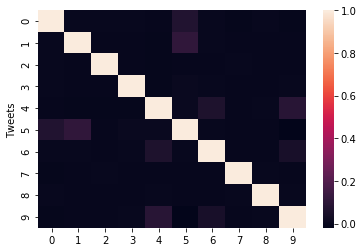

Key:
0 Yesterday we lost a courageous president and one of the greatest members of the Greatest Generation, George H.W. Bu… https://t.co/xpvghmiiO2
1 Walmart’s decision to provide 48 hours of paid sick leave to some employees is a small step forward, but not nearly… https://t.co/3yosQYPaKN
2 A state legislator once brushed off Cassandra Levesque’s campaign to end child marriage in New Hampshire as “a requ… https://t.co/3RrlsKqkid
3 The only Collusion with the Russians was with Crooked Hillary Clinton and the Democratic National Committee...And,… https://t.co/ojVg7Xi9Fs
4 Ten-year-old Jahkil Jackson is on a mission to help homeless people in Chicago. He created kits full of socks, toil… https://t.co/7mNk6dmnyC
5 Over 2,400 American patriots lost their lives in the attack on Pearl Harbor nearly 77 years ago—it’s a sacred place… https://t.co/VsjUwLDXlc
6 These talented young people will create a better future not just in Africa, but around the world. I can’t wait to s… https://t.co/0YgQxn

In [134]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


Above heatmap shows the sentences doesnt look to be similar at all.It is able to correctly differentiate sentences

# Classification Clustering Using LSA



## Using K-Means Clusters

In [90]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# Normalize the data.
X_norm = normalize(X_train_lsa)

# Calculate predicted values.
y_pred = KMeans(n_clusters=25, random_state=42).fit_predict(X_norm)

# Check the solution against the data.
print('Comparing k-means clusters against politicians:')
pd.crosstab(y_train, y_pred)

Comparing k-means clusters against politicians:


col_0,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Author,,,,,,,,,,,,,,,,,,,,,
BarackObama,8,5,60,4,38,30,12,5,1,5,...,8,1,1,4,0,14,28,5,23,20
HillaryClinton,10,24,60,11,15,28,4,7,3,2,...,11,6,19,38,5,35,28,5,23,3
MikeBloomberg,20,15,6,78,6,41,19,2,4,14,...,0,8,4,9,7,7,21,10,25,0
SenSanders,8,23,39,11,0,5,6,16,14,3,...,2,36,12,53,39,11,11,9,22,2
realDonaldTrump,15,16,6,1,2,8,19,6,5,28,...,8,3,4,38,4,16,21,27,29,0


Lets try LSA to check the accuracy using Random Forest.This is a superivsed approach to check how LSA  impacted the accuracy

In [102]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

rfc_lsa1 = ensemble.RandomForestClassifier(random_state=42)
rfc_lsa1.fit(X_train_lsa,y_train)
cv_lsa1 = cross_val_score(rfc_lsa1, X_train_lsa, y_train, cv=5)


#Test
y_true, y_pred = y_train, rfc_lsa1.predict(X_train_lsa)
print("Test Set score = {:.3} ".format(accuracy_score(y_true, y_pred)))


print("Training set Cross validation = {}".format(cv_lsa1))
print("mean = {:.3}".format(cv_lsa1.mean()))
print(pd.crosstab(y_true, y_pred))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test Set score = 1.0 
Training set Cross validation = [0.79575597 0.8        0.83466667 0.81550802 0.82085561]
mean = 0.813
col_0            BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
Author                                                                    
BarackObama              361               0              0           0   
HillaryClinton             0             390              0           0   
MikeBloomberg              0               0            381           0   
SenSanders                 0               0              0         373   
realDonaldTrump            0               0              0           0   

col_0            realDonaldTrump  
Author                            
BarackObama                    0  
HillaryClinton                 0  
MikeBloomberg                  0  
SenSanders                     0  
realDonaldTrump              370  


Oh no!these new features did not help at all .We can see overfitting.Like try logistic Regression

In [98]:
logit = LogisticRegression()
fit = logit.fit(X_train_lsa_df, y_train)
y_pred = logit.predict(X_train_lsa_df)
print ('Training set score:', rfc.score(X_train_lsa_df, y_train))


C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.9994666666666666


In [100]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train_lsa_df, y_train)
y_pred_knn = clf.predict(X_train_lsa_df)
print('Training set score:', clf.score(X_train_lsa_df, y_train))


Training set score: 0.9994666666666666


In [103]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc_model = svc.fit(X_train_lsa,y_train)
print(svc_model)
print('Training set score:', svc_model.score(X_train_lsa,y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training set score: 0.9861333333333333


In [105]:
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
svm_t200 = SVC(kernel='linear')
svm_t200.fit(X_train_lsa,y_train)
svm_t200_cv = cross_val_score(svm_t200, X_train_lsa, y_train, cv=5)


print("Report:")
y_true, y_pred = y_train, svm_t200.predict(X_train_lsa)
#print(classification_report(y_true, y_pred))

print("Test Set score = {:.3} ".format(accuracy_score(y_train, y_pred)))


print("Training set Cross validation = {}".format(svm_t200_cv))
print("mean = {:.3}".format(svm_t200_cv.mean()))
print(pd.crosstab(y_true, y_pred))

Report:
Test Set score = 0.986 
Training set Cross validation = [0.90981432 0.89333333 0.90666667 0.90374332 0.90374332]
mean = 0.903
col_0            BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
Author                                                                    
BarackObama              354               3              1           2   
HillaryClinton             3             385              1           0   
MikeBloomberg              0               2            376           2   
SenSanders                 0               0              0         371   
realDonaldTrump            3               3              0           1   

col_0            realDonaldTrump  
Author                            
BarackObama                    1  
HillaryClinton                 1  
MikeBloomberg                  1  
SenSanders                     2  
realDonaldTrump              363  


In [106]:
pd.crosstab(y_true, y_pred, margins = True)

col_0,BarackObama,HillaryClinton,MikeBloomberg,SenSanders,realDonaldTrump,All
Author,,,,,,
BarackObama,354,3,1,2,1,361
HillaryClinton,3,385,1,0,1,390
MikeBloomberg,0,2,376,2,1,381
SenSanders,0,0,0,371,2,373
realDonaldTrump,3,3,0,1,363,370
All,360,393,378,376,368,1875


This looks little better as compared to Linear Regression, GBC,Random Forest which don't perform well with humongous features like this dataset has.

# Conclusion:

Overall, the dataset cooperated with tf-idf better than Bag of Words.Latent Semantic Analysis did a fair job in identying the similar tweets.As we notice, most of the tweets it identified were for - Gun law,Voting, obama care, Climate change and Trump policy, which it was able to identify. Clustering  proved to be ineffective in classifying tweets and only returned one cluster when using mean-shift.
KNN proved to be the most effective model for all the features with bow/Tf-idf.All the other models had overfitting which coulnot perform well with such huge number of features.BoW and TF-idf operated very differently in accurately identifying authors in their tweets. Clustering with LSA seem to perform ok.Mini batch k means clustering seem to perform better for clustering the author with their tweets than k means.It does look like supervised learning performed better in clustering the data compared to unsupervised learning